In [1]:
import hypernetx as hnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
warnings.simplefilter('ignore')

The `hypernetx` library can construct hypergraphs from many python data structures (lists, dictionaries, etc.)

Here I focus on what should matter in the mathematical approach, i.e. the **incidence matrices**.

I'll think of Gatien's [2025 work](https://journals.aps.org/pre/abstract/10.1103/4rsy-786t) paper and try to implement a piece of the circuit in Fig 1.


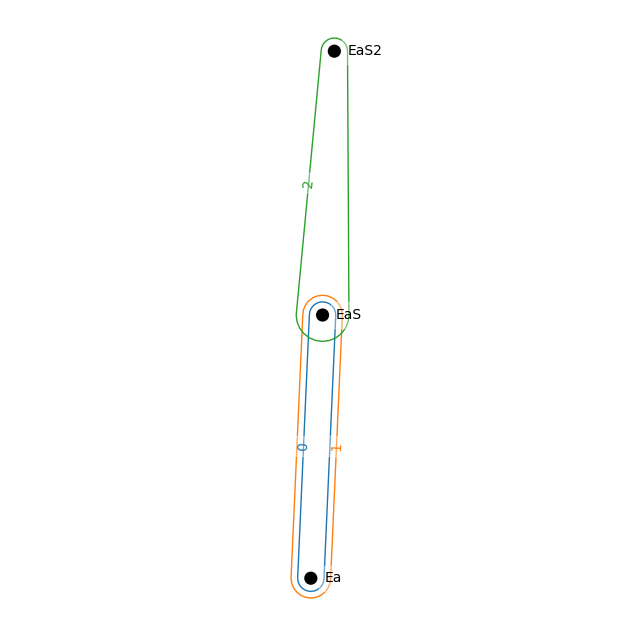

In [2]:
# incidence matrix for the inner part of the top circuit
# the rows are the verrtices and the columns are the hyperdges
# if an element ij is nonzero, then the vertex i is in the hyperdge j

#  here the row
# 0 -> Ea
# 1 -> EaS
# 2 -> EaS2
#  
# while the column
# 0 -> reaction 1
# 1 -> reaction 2
# 2 -> reaction3


inner_1 = np.array([
    [-1,1,0],
    [1,-1,-1],
    [0,0,1]

])
node_labels = {0:'Ea', 1:'EaS', 2:'EaS2'}
H = hnx.Hypergraph.from_incidence_matrix(inner_1)

hnx.draw(H, node_labels = node_labels)

# print(H.dataframe)

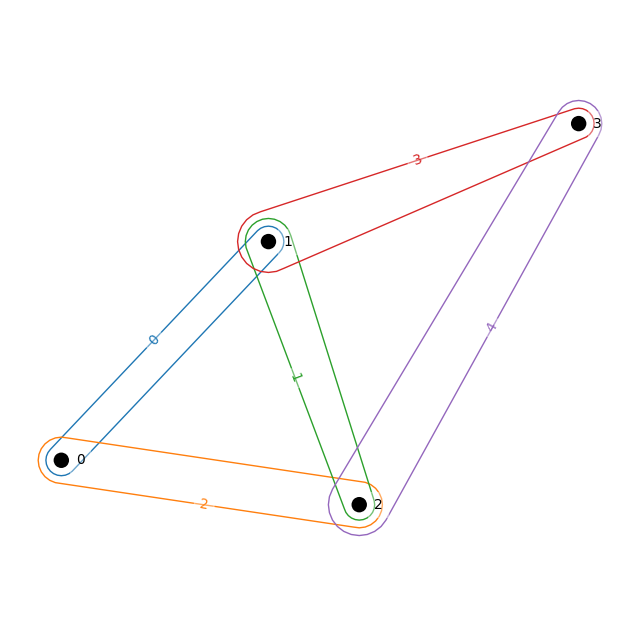

In [3]:
inner_2 = np.array([
[-1,0,1,0,0],
[1,-1,0,-1,0],
[0,1,-1,0,1],
[0,0,0,1,-1]
])
# node_labels = {0:'Ea', 1:'EaS', 2:'EaS2'}
H = hnx.Hypergraph.from_incidence_matrix(inner_2)

hnx.draw(H)# node_labels = node_labels)


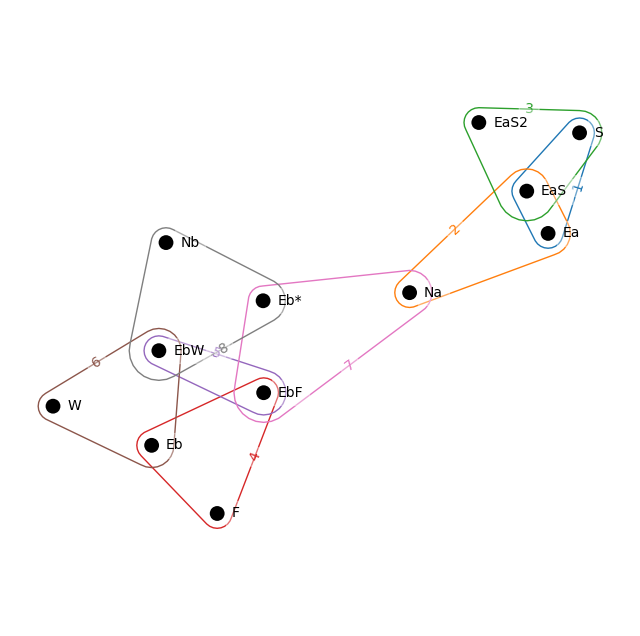

In [4]:
# full network
import matplotlib.pyplot as plt
# rows are nots, columns are edges (reactions)
graph = {
            1:["S","Ea", "EaS"],
          2:["Ea", "EaS", "Na"],
          3:["EaS","S", "EaS2"],
          4:["F", "Eb","EbF"],
          5:["EbF","EbW"],
          6:["EbW", "Eb","W"],
          7:["EbF", "Na","Eb*"],
          8:["Eb*", "EbW", "Nb"]
          
          }

# print(H.dataframe)
H = hnx.Hypergraph(graph)
hnx.draw(H)
plt.savefig("graph.pdf")

It seem that for the **stoichiometric matrices** Gatien essentially uses a matrix with some labellling to keep track of what the roows are, distinguishing the upper and the lower block for the interal and external species:

- the internal above the line
- the external below the line

Therefore I construct a custom class to encode that:

In [5]:
import numpy as np
import sympy

class LabelledStoichiometricMatrix:
    def __init__(self,matrix, last_internal):
        """Construct a labelled stoichiometric matrix from a complete matrix where we keep track of internal and external species.
        
        Args:
            matrix (np.ndarray): The complete matrix
            last_internal (int): The index (0-based) of the last internal species (below which all the rows are external)"""
        self.complete = matrix
        self.last_internal = last_internal
        self.internal = matrix[:last_internal+1]
        self.external = matrix[last_internal+1:]
    def __repr__(self):
        
        # Determine column width based on the longest number in any row
        col_width = max(len(str(x)) for row in self.complete for x in row) + 1
        
        repr_str = ""
        for i, row in enumerate(self.complete):
            # Format each row with right-aligned numbers
            string_row = " ".join(f"{x:>{col_width}}" for x in row)
            
            # Insert horizontal line after `last_internal+1` row
            if i == self.last_internal + 1:
                repr_str += "-" * (len(string_row)) + "\n"
            
            repr_str += string_row + "\n"
        
        return repr_str
    


## Implementing the example for good


### Stoichiometric matrices

We start by defining the two **stoichiometric** matrices of Gatien's example. 

In [6]:
nabla_1 = LabelledStoichiometricMatrix(

    np.array([
        [-1,1,0],
        [1,-1,-1],
        [0,0,1],
        [-1,0,-1],
        [0,1,0],]),
        2
)
nabla_1

 -1   1   0
  1  -1  -1
  0   0   1
-----------
 -1   0  -1
  0   1   0

In [7]:
nabla_2 = LabelledStoichiometricMatrix(

    np.array([
        [-1,0,1,0,0],
        [1,-1,0,-1,0],
        [0,1,-1,0,1],
        [0,0,0,1,-1],
        [0,0,0,-1,0],
        [0,0,0,0,1],
        [-1,0,0,0,0],
        [0,0,1,0,0],
        ]),
        3
)
nabla_2

 -1   0   1   0   0
  1  -1   0  -1   0
  0   1  -1   0   1
  0   0   0   1  -1
-------------------
  0   0   0  -1   0
  0   0   0   0   1
 -1   0   0   0   0
  0   0   1   0   0

### Currents

I try to do this symbolically to check.



In [8]:
import sympy

j1, j2, j3, j4, j5, j6, j7, j8 = sympy.symbols("j1 j2 j3 j4 j5 j6 j7 j8")


_j1 = sympy.Matrix([[j1],[j2],[j3]])

_j2 = sympy.Matrix([[j4],[j5],[j6],[j7],[j8]])

_j2

Matrix([
[j4],
[j5],
[j6],
[j7],
[j8]])

### Cycles

In [9]:
from scipy.linalg import null_space
from scipy.linalg import lu


In [10]:
C_inner_1 = sympy.Matrix(nabla_1.internal).nullspace()[0]
C_inner_1


Matrix([
[1],
[1],
[0]])

In [11]:
_C_inner_2 = sympy.Matrix(nabla_2.internal).nullspace()
# rearrange 
C_inner_2 = sympy.Matrix([_C_inner_2])

C_inner_2

Matrix([
[1,  0],
[1, -1],
[1,  0],
[0,  1],
[0,  1]])

This is different from Gatien's but they should be equivalent (TEST this). A way to test this is to find an inveritble matrix P that transforms this into the other so that 

$$C_{\rm scipy} P = C_{\r Gatien}$$

I assume that this works and go ahead with the code.

So I can start by testing that 

$$\boldsymbol{\nabla}_{\mathrm{internal}} \boldsymbol{j}=\mathbf{0}$$



In [12]:
constraint_1 = sympy.solve (nabla_1.internal*_j1, _j1)
constraint_1

{j1: j2, j3: 0}

In [13]:
constraint_2 = sympy.solve (nabla_2.internal*_j2, _j2)

constraint_2

{j4: j6, j5: j6 - j8, j7: j8}

Which all together are equations (54,55) of Gatien's paper.



Now recreating equation (56) and (57) using the psuedoinverse of the cycle matricies 

This creates the fundamental currents which we use later




In [14]:
I_1 = (C_inner_1.pinv()*_j1).subs(constraint_1)

I_1

Matrix([[j2]])

In [15]:
I_2 = (C_inner_2.pinv()*_j2).subs(constraint_2)

I_2

Matrix([
[j6],
[j8]])

The same for 83-84

In [16]:
i_1 = (-nabla_1.external*_j1).subs(constraint_1)

i_1

Matrix([
[ j2],
[-j2]])

In [17]:
i_2 = (-nabla_2.external*_j2).subs(constraint_2)

i_2

Matrix([
[ j8],
[-j8],
[ j6],
[-j6]])

### Conservation laws

It is not very clear to me how you draw the horizontal/vertical lines to identify the various bits of the conservation laws

- the vertical line should simply be the interval vs external species
- the horizontal line seems to be just after the first row, but it is not clear why. There must be a simple way to figure this out automatically.

In [18]:
ell1 =sympy.Matrix([sympy.Matrix(nabla_1.complete).T.nullspace()]).T

ell1


Matrix([
[ 1,  1, 1, 0, 0],
[-2, -1, 0, 1, 1]])

In [19]:
ell2 =sympy.Matrix([sympy.Matrix(nabla_2.complete).T.nullspace()]).T

ell2


Matrix([
[ 1,  1,  1, 1, 0, 0, 0, 0],
[-1, -1, -1, 0, 1, 1, 0, 0],
[-1,  0,  0, 0, 0, 0, 1, 1]])

Finding $\phi=\nabla_yC$ equation (24) ($\phi$ is the matrix of physical exchanges (columns provide the matter exchanged with chemostats during each cycle)).

In [20]:
phy_1=nabla_1.external*C_inner_1
phy_2=nabla_2.external*C_inner_2

phy_2

Matrix([
[ 0, -1],
[ 0,  1],
[-1,  0],
[ 1,  0]])

Finding $l$ from $l\phi=0$ equation (24) (Conservation Laws For Chemostat Currents (clfcc))

In [21]:
clfcc_1 =sympy.Matrix([sympy.Matrix(phy_1).T.nullspace()]).T
clfcc_2 =sympy.Matrix([sympy.Matrix(phy_2).T.nullspace()]).T

clfcc_1

Matrix([[1, 1]])

Creating the selection matricies from the kernels of the clfccs

In [22]:
_C_inner_2 = sympy.Matrix(nabla_2.internal).nullspace()
# rearrange 
C_inner_2 = sympy.Matrix([_C_inner_2])

_S_1 = sympy.Matrix(clfcc_1).nullspace()
__S_1 = sympy.Matrix([_S_1])
__S_1

_S_2 = sympy.Matrix(clfcc_2).nullspace()
__S_2 = sympy.Matrix([_S_2])
__S_2

Matrix([
[-1,  0],
[ 1,  0],
[ 0, -1],
[ 0,  1]])

Now defining the Chemical Potentials vector

In [23]:
mu_Ea, mu_EaS, mu_EaS2, mu_S, mu_Na, mu_Eb, mu_EbF, mu_EbW, mu_Eb_star, mu_Nb, mu_F, mu_W = sympy.symbols("mu_Ea mu_EaS mu_EaS2 mu_S mu_Na mu_Eb mu_EbF mu_EbW mu_Eb_star mu_Nb mu_F mu_W")
_mu_1 = sympy.Matrix([[mu_Ea],[mu_EaS],[mu_EaS2],[mu_S],[mu_Na]])

_mu_2 = sympy.Matrix([[mu_Eb],[mu_EbF],[mu_EbW],[mu_Eb_star],[mu_Na],[mu_Nb],[mu_F],[mu_W]])

_mu_2

Matrix([
[     mu_Eb],
[    mu_EbF],
[    mu_EbW],
[mu_Eb_star],
[     mu_Na],
[     mu_Nb],
[      mu_F],
[      mu_W]])

Now finding the thermodynamic forces with $f=-(\nabla^T\mu)$ equation (5) to produce equations (66) & (67)

In [24]:
_f_1 = sympy.Matrix([sympy.Matrix(-nabla_1.complete).T * _mu_1])
_f_2 = sympy.Matrix([sympy.Matrix(-nabla_2.complete).T * _mu_2])

_f_2

Matrix([
[       mu_Eb - mu_EbF + mu_F],
[             mu_EbF - mu_EbW],
[      -mu_Eb + mu_EbW - mu_W],
[ mu_EbF - mu_Eb_star + mu_Na],
[-mu_EbW + mu_Eb_star - mu_Nb]])

Determining cycle forces with $F=C^Tf$ to produce equations (68) & (69)

In [25]:
_F_1 = sympy.Matrix([C_inner_1.T * _f_1])
_F_2 = sympy.Matrix([C_inner_2.T * _f_2])
_F_2

Matrix([
[  mu_F - mu_W],
[mu_Na - mu_Nb]])

Generating generic diagonal resistance matricies equation (74) and (75)

In [26]:
r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8 = sympy.symbols("r_1 r_2 r_3 r_4 r_5 r_6 r_7 r_8")
__r_1 = sympy.diag(r_1, r_2, r_3)
__r_2 = sympy.diag(r_4,r_5,r_6,r_7,r_8)

__r_2

Matrix([
[r_4,   0,   0,   0,   0],
[  0, r_5,   0,   0,   0],
[  0,   0, r_6,   0,   0],
[  0,   0,   0, r_7,   0],
[  0,   0,   0,   0, r_8]])

The Cycle resistance matricies obtained from $R=C^TrC$ (eq35) to produce eq (76) & (77)

In [27]:
__R_1 = C_inner_1.T * __r_1 * C_inner_1
__R_2 = C_inner_2.T * __r_2 * C_inner_2

__R_2

Matrix([
[r_4 + r_5 + r_6,            -r_5],
[           -r_5, r_5 + r_7 + r_8]])

In [28]:
__g_1 = phy_1 * (__R_1.inv()) * phy_1.T
__g_2 = phy_2 * (__R_2.inv()) * phy_2.T

__g_1

Matrix([
[ 1/(r_1 + r_2), -1/(r_1 + r_2)],
[-1/(r_1 + r_2),  1/(r_1 + r_2)]])

Determing the conductance matrices at fundamental level

In [29]:
__G_1 = __S_1.pinv() * __g_1 * __S_1.T.pinv()

__G_2 = __S_2.pinv() * __g_2 * __S_2.T.pinv()

__G_2 

Matrix([
[(r_4 + r_5 + r_6)/(r_4*r_5 + r_4*r_7 + r_4*r_8 + r_5*r_6 + r_5*r_7 + r_5*r_8 + r_6*r_7 + r_6*r_8),               r_5/(r_4*r_5 + r_4*r_7 + r_4*r_8 + r_5*r_6 + r_5*r_7 + r_5*r_8 + r_6*r_7 + r_6*r_8)],
[              r_5/(r_4*r_5 + r_4*r_7 + r_4*r_8 + r_5*r_6 + r_5*r_7 + r_5*r_8 + r_6*r_7 + r_6*r_8), (r_5 + r_7 + r_8)/(r_4*r_5 + r_4*r_7 + r_4*r_8 + r_5*r_6 + r_5*r_7 + r_5*r_8 + r_6*r_7 + r_6*r_8)]])

In [30]:
_i_1r = sympy.Matrix([-j2])
_i_3 = sympy.Matrix([[j1],[-j8],[j6],[-j6]])

_i_3

Matrix([
[ j1],
[-j8],
[ j6],
[-j6]])

Defining $L_i$ and $L_e$ (86) in future I would like to automate this to determine it from previous conservation law matrices

In [31]:
__L_i = sympy.Matrix([[-1], [1], [0]])

__L_e = sympy.Matrix([[1,0,0,0], [0,1,0,0], [0,0,1,1]])

__L_e


Matrix([
[1, 0, 0, 0],
[0, 1, 0, 0],
[0, 0, 1, 1]])

Taking the cokernel of $L_i$

In [32]:
_nu_rows = __L_i.T.nullspace()
__nu = sympy.Matrix.hstack(*_nu_rows).T
__nu

Matrix([
[1, 1, 0],
[0, 0, 1]])

and using the result to determine the conservation laws of module 3 equation (89)

In [33]:
__l_3 = __nu * __L_e

__l_3

Matrix([
[1, 1, 0, 0],
[0, 0, 1, 1]])

Determining the corresponding selection matrix for these conservation laws

In [34]:
_S_3 = sympy.Matrix(__l_3).nullspace()
__S_3 = sympy.Matrix([_S_3])
__S_3

Matrix([
[-1,  0],
[ 1,  0],
[ 0, -1],
[ 0,  1]])

In [35]:
__pi = __L_i.pinv() * __L_e

__pi

Matrix([[-1/2, 1/2, 0, 0]])

In [36]:
__pi_13 = sympy.Matrix([[1,0,0,0],[-1/2,1/2,0,0]])
__pi_23 = sympy.Matrix([[1/2,-1/2,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])

__pi_23

Matrix([
[0.5, -0.5, 0, 0],
[  0,    1, 0, 0],
[  0,    0, 1, 0],
[  0,    0, 0, 1]])

In [37]:
__PI_13 = __S_1.pinv() * __pi_13 * __S_3
__PI_23 = __S_2.pinv() * __pi_23 * __S_3

__PI_23 


Matrix([
[1.0, 0],
[  0, 1]])

Producing equation (99) with equation (98)

In [38]:
__G_3 = __PI_13.T * __G_1.inv() * __PI_13 + __PI_23.T * __G_2.inv() * __PI_23

__G_3 

Matrix([
[1.0*r_1 + 1.0*r_2 + 1.0*r_5 + 1.0*r_7 + 1.0*r_8,        -1.0*r_5],
[                                       -1.0*r_5, r_4 + r_5 + r_6]])

In [39]:
import sympy
class ModuleCombination:
    
    def __init__(self, i_1_l, i_1_r, i_1, i_2_l, i_2_r, i_2, i_3, l_1, l_2, S_1, S_2, S_3, __G_1, __G_2):
        self.i_1_l = i_1_l
        self.i_1_r = i_1_r
        self.i_1 = i_1
        self.i_2_l = i_2_l
        self.i_2_r = i_2_r
        self.i_2 = i_2
        self.i_3 = i_3
        self.l_1 = l_1 
        self.l_2 = l_2
        self.S_1 = S_1
        self.S_2 = S_2  
        self.S_3 = S_3
        self.__G_1 = __G_1
        self.__G_2 = __G_2


    def ConservationLaws(self):
        self.length_i_1_l = len(self.i_1_l)
        self.length_i_1_r = len(self.i_1_r)
        self.l_1_l = self.l_1[:, :self.length_i_1_l]
        self.l_1_r = self.l_1[:, self.length_i_1_l:]
        
        self.length_i_2_l = len(self.i_2_l)
        self.length_i_2_r = len(self.i_2_r)
        self.l_2_l = self.l_2[:, :self.length_i_2_l]
        self.l_2_r = self.l_2[:, self.length_i_2_l:]
        
        self.L_i = sympy.Matrix.vstack(-self.l_1_r, self.l_2_l)
        
        L_e = sympy.BlockMatrix([
        [self.l_1_l, sympy.ZeroMatrix(self.l_1_l.shape[0], self.l_2_r.shape[1])],
        [sympy.ZeroMatrix(self.l_2_r.shape[0], self.l_1_l.shape[1]), self.l_2_r]])
        self.L_e = sympy.Matrix(L_e)
        
        self.pi = sympy.Matrix(self.L_i.pinv() * self.L_e)

        self.pi_rows, self.pi_cols = self.pi.shape

        self.identity_part_1 = sympy.eye(self.length_i_1_l, self.pi_cols)
        self.pi_1_3 = self.identity_part_1.col_join(self.pi)

        self.identity_part_2 = sympy.eye(self.length_i_2_r, self.pi_cols-self.pi_rows)
        self.zeros_part_2 = sympy.zeros(self.length_i_2_r, self.pi_rows)
        self.bottom_part_2 = self.zeros_part_2.row_join(self.identity_part_2)
        self.pi_2_3 = (-self.pi).col_join(self.bottom_part_2)

        self.PI_1_3 = sympy.Matrix(self.S_1.pinv() * self.pi_1_3 * self.S_3)
        self.PI_2_3 = sympy.Matrix(self.S_2.pinv() * self.pi_2_3 * self.S_3)

        self.G_3 = self.PI_1_3.T * self.__G_1.inv() * self.PI_1_3 + self.PI_2_3.T * self.__G_2.inv() * self.PI_2_3

        



j_1, j_6, j_8 = sympy.symbols('j_1 j_6 j_8')
i_1_l = sympy.Matrix([j_1])
i_1_r = sympy.Matrix([-j_1])
i_1 = sympy.Matrix([j_1,-j_1])
i_2_l = sympy.Matrix([j_1])
i_2_r = sympy.Matrix([-j_8,j_6,-j_6])
i_2 = sympy.Matrix([j_1,-j_1,j_6,-j_6])
i_3 = sympy.Matrix([j_1,-j_1,j_6,-j_6])
l_1 = sympy.Matrix([[1,1]])
l_2 = sympy.Matrix([[1,1,0,0],[0,0,1,1]])
S_1 = sympy.Matrix([1,-1])
S_2 = sympy.Matrix([[1,0],[-1,0],[0,1],[0,-1]])
S_3 = sympy.Matrix([[1,0],[-1,0],[0,1],[0,-1]])



example1 = ModuleCombination(i_1_l, i_1_r, i_1, i_2_l, i_2_r, i_2, i_3, l_1, l_2, S_1, S_2, S_3, __G_1, __G_2)
example1.ConservationLaws()
example1.G_3


Matrix([
[r_1 + r_2 + r_5 + r_7 + r_8,            -r_5],
[                       -r_5, r_4 + r_5 + r_6]])